# Notes on Chapter 3 of Statistical Rethinking 2nd Edition by Richard McElreath

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [2]:
from functools import partial
import math
from math import pi
import warnings

import jax
from jax import numpy as jnp
from jax import scipy as jsp
from jax import random as jr
from jax.scipy import optimize as jspopt
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow import math as tfm
from tensorflow_probability import distributions as tfd
from tensorflow_probability.substrates import jax as jtfp
from tensorflow_probability.substrates.jax import distributions as jtfd

In [3]:
warnings.resetwarnings()

# JAX's percentile function tries to use FP64 which generates a warning that
# we do not care about here.
warnings.filterwarnings(
    "ignore",
    category=UserWarning, 
    message=r".*Explicitly requested dtype <class 'jax.numpy.\w*64'> " +
        r"requested in \w* is not available.*"
)
# JAX's percentile function also somtimes triggers a deprecation warning from
# sort that we can't fix here.
warnings.filterwarnings(
    "ignore",
    category=DeprecationWarning, 
    message=r"The 'kind' argument to sort has no effect, and is deprecated\.",
)

# Loading the rethinking library under Rpy2 triggers a deprecation warning
# that we can't fix here.
warnings.filterwarnings(
    "ignore",
    category=DeprecationWarning, 
    message=r"The `source` parameter emit a  deprecation warning since IPython",
)

In [4]:
%load_ext rpy2.ipython

In [5]:
%%R

library(rethinking)

Loading required package: rstan
Loading required package: StanHeaders

rstan version 2.32.6 (Stan version 2.32.2)

For execution on a local, multicore CPU with excess RAM we recommend calling
options(mc.cores = parallel::detectCores()).
To avoid recompilation of unchanged Stan programs, we recommend calling
rstan_options(auto_write = TRUE)
For within-chain threading using `reduce_sum()` or `map_rect()` Stan functions,
change `threads_per_chain` option:
rstan_options(threads_per_chain = 1)

Loading required package: cmdstanr
This is cmdstanr version 0.7.1
- CmdStanR documentation and vignettes: mc-stan.org/cmdstanr
- Use set_cmdstan_path() to set the path to CmdStan
- Use install_cmdstan() to install CmdStan
Loading required package: parallel
rethinking (Version 2.21)

Attaching package: ‘rethinking’

The following object is masked from ‘package:rstan’:

    stan

The following object is masked from ‘package:stats’:

    rstudent

In addition: Warning messages:
1: In (function (n)  :
  

### 3.1

In [6]:
%%R

Pr_Positive_Vampire <- 0.95
Pr_Positive_Mortal <- 0.01
Pr_Vampire <- 0.001
Pr_Positive <- Pr_Positive_Vampire * Pr_Vampire + Pr_Positive_Mortal * (1 - Pr_Vampire)
Pr_Vampire_Positive <- Pr_Positive_Vampire * Pr_Vampire / (Pr_Positive_Vampire * Pr_Vampire + Pr_Positive_Mortal * (1 - Pr_Vampire))
Pr_Vampire_Positive

[1] 0.08683729


There's no advantage to using tensorflow if we're just using python as a calculator, so the python code is virtually identical to the R code:

In [7]:
Pr_Positive_Vampire = 0.95
Pr_Positive_Mortal = 0.01
Pr_Vampire = 0.001
Pr_Positive = Pr_Positive_Vampire * Pr_Vampire + Pr_Positive_Mortal * (1 - Pr_Vampire)
Pr_Vampire_Positive = Pr_Positive_Vampire * Pr_Vampire / (Pr_Positive_Vampire * Pr_Vampire + Pr_Positive_Mortal * (1 - Pr_Vampire))
Pr_Vampire_Positive

0.08683729433272395

### 3.2

In [8]:
%%R

p_grid <- seq(from=0, to=1, length.out=1000)
prob_p <- rep(1, 1000)
prob_data <- dbinom(6, size=9, prob=p_grid)
posterior <- prob_data * prob_p
posterior <- posterior / sum(posterior)

In [9]:
p_grid = tf.linspace(0., 1., 1000)
prob_p = tf.ones_like(p_grid)
prob_data = tfd.Binomial(9, probs=p_grid).prob(6)
posterior = prob_data * prob_p
posterior = posterior / tfm.reduce_sum(posterior)

In [10]:
jp_grid = jnp.linspace(0., 1., 1000)
jprob_p = jnp.ones_like(jp_grid)
jprob_data = jtfd.Binomial(9, probs=jp_grid).prob(6)
jposterior = jprob_data * jprob_p
jposterior = jposterior / jposterior.sum()

### 3.3

In [11]:
%%R

samples <- sample(p_grid, prob=posterior, size=1e4, replace=TRUE)

In [12]:
samples = tf.gather(p_grid, tfd.Categorical(probs=posterior).sample(10000))

In [13]:
key = jr.key(42)
key,seed = jr.split(key)
jsamples = jr.choice(a=jp_grid, shape=(10000,), p=jposterior, key=key)

### 3.4

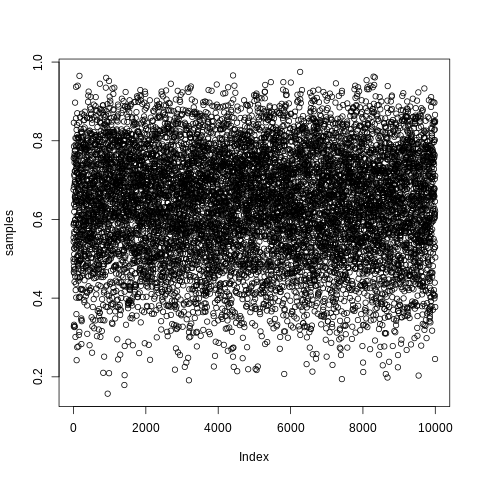

In [14]:
%%R

plot(samples)

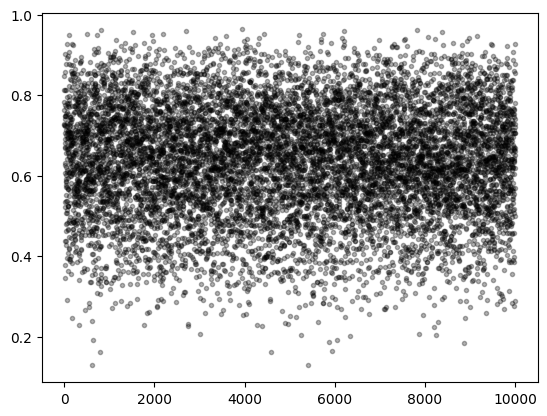

In [15]:
plt.plot(samples, '.k', alpha=0.3);

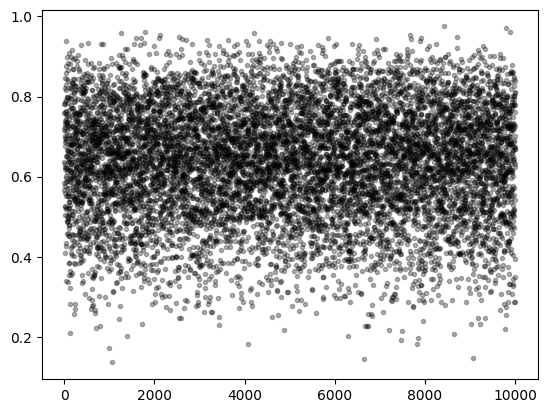

In [16]:
plt.plot(jsamples, '.k', alpha=0.3);

### 3.5

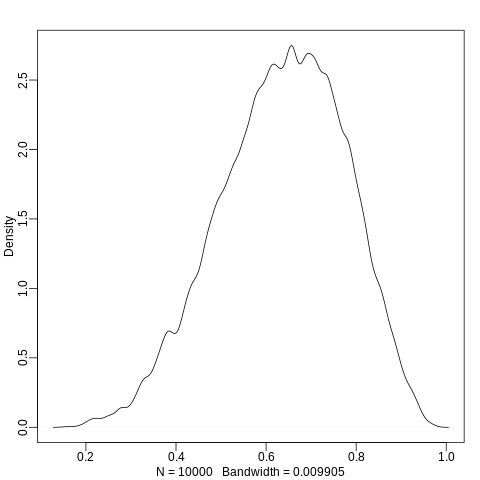

In [17]:
%%R

library(rethinking)
dens(samples)

<Axes: ylabel='Density'>

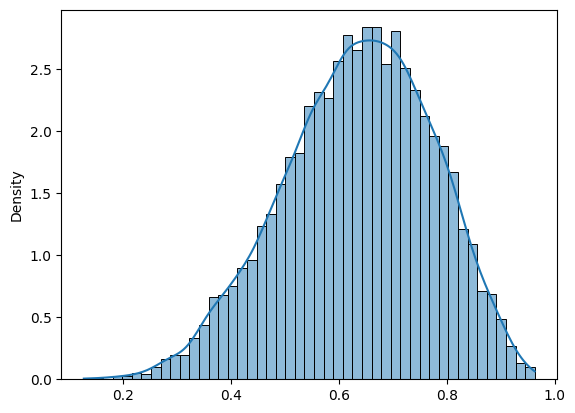

In [18]:
sns.histplot(samples, kde=True, stat='density')

<Axes: ylabel='Density'>

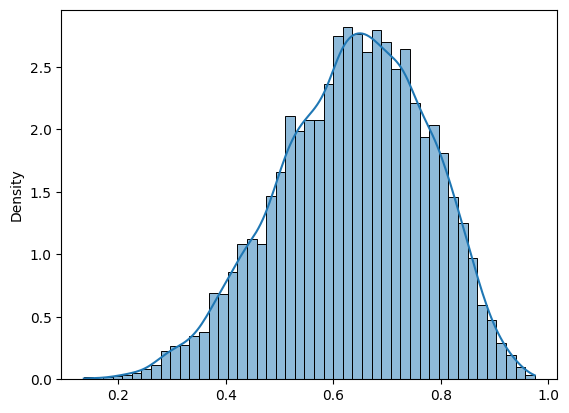

In [19]:
sns.histplot(jsamples, kde=True, stat='density')

### 3.6

In [20]:
%%R

sum(posterior[p_grid < 0.5])

[1] 0.1718746


In [21]:
tf.reduce_sum(posterior[p_grid < 0.5])

<tf.Tensor: shape=(), dtype=float32, numpy=0.17187457>

In [22]:
jposterior[jp_grid < 0.5].sum()

Array(0.17187458, dtype=float32)

### 3.7

In [23]:
%%R

sum(samples < 0.5) / 1e4

[1] 0.1741


In [24]:
tf.reduce_sum(tf.cast(samples < 0.5, tf.float32)) / samples.shape[0]

<tf.Tensor: shape=(), dtype=float32, numpy=0.1709>

In [25]:
(jsamples < 0.5).mean()

Array(0.16839999, dtype=float32)

### 3.8

In [26]:
%%R

sum(samples > 0.5 & samples < 0.75) / 1e4

[1] 0.6011


In [27]:
tf.reduce_sum(tf.cast(tf.logical_and(samples > 0.5, samples < 0.75), tf.float32)) / samples.shape[0]

<tf.Tensor: shape=(), dtype=float32, numpy=0.6101>

In [28]:
((0.5 < jsamples) * (jsamples < 0.75)).mean()

Array(0.60929996, dtype=float32)

### 3.9

In [29]:
%%R

quantile(samples, 0.8)

      80% 
0.7607608 


In [30]:
tfp.stats.percentile(samples, 80)

<tf.Tensor: shape=(), dtype=float32, numpy=0.7587587>

In [31]:
jtfp.stats.percentile(jsamples, 80)

Array(0.7607607, dtype=float32)

### 3.10

In [32]:
%%R

quantile(samples, c(0.1, 0.8))

      10%       80% 
0.4484484 0.7607608 


In [33]:
tfp.stats.percentile(samples, (10, 80))

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([0.44944945, 0.7587587 ], dtype=float32)>

In [34]:
jtfp.stats.percentile(jsamples, (10, 80))

Array([0.44644645, 0.7607607 ], dtype=float32)

### 3.11

In [35]:
%%R

p_grid <- seq(from=0, to=1, length.out=1000)
prior <- rep(1, 1000)
likelihood <- dbinom(3, size=3, prob=p_grid)
posterior <- likelihood * prior
posterior <- posterior / sum(posterior)
samples <- sample(p_grid, size=1e4, replace=TRUE, prob=posterior)

In [36]:
p_grid = tf.linspace(0., 1., 1000)
prior = tf.ones_like(p_grid)
likelihood = tfd.Binomial(3, probs=p_grid).prob(3)
posterior = likelihood * prior
posterior = posterior / tfm.reduce_sum(posterior)
samples = tf.gather(p_grid, tfd.Categorical(probs=posterior).sample(10000))

In [37]:
key = jr.key(42)
key,seed = jr.split(key)

jp_grid = jnp.linspace(0., 1., 1000)
jprior = jnp.ones_like(jp_grid)
jlikelihood = jtfd.Binomial(3, probs=jp_grid).prob(3)
jposterior = jlikelihood * jprior
jposterior = jposterior / jposterior.sum()
jsamples = jr.choice(a=jp_grid, p=jposterior, shape=(10000,), key=seed)

### 3.12

In [38]:
%%R

PI(samples, prob=0.5)

      25%       75% 
0.7067067 0.9309309 


Since we don't have a python version of the author's library (yet), we have to write our own PI function.

In [39]:
def PI(samples, prob):
    # for performance reasons tensorflow probability only provides an O(n) 
    # approximation of quantiles rather than an O(n log(n)) exact computation
    n_quantiles = max(1000, int(samples.shape[0]**0.5))
    all_quantiles = tfp.stats.quantiles(samples, n_quantiles)
    quantile_indexes = tf.cast(
        n_quantiles * tf.constant([(1 - prob)/2, (1 + prob)/2]), tf.int32)
    return tf.gather(all_quantiles, quantile_indexes)

PI(samples, prob=0.5)

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([0.7087087, 0.9299299], dtype=float32)>

In [40]:
@jax.jit
def jPI(samples, prob):
    n = samples.shape[0]
    sorted_samples = jnp.sort(samples)
    return sorted_samples[jnp.array([(n*(1 - prob)/2), (n*(1 + prob)/2)]).astype(int)]

jPI(jsamples, prob=0.5)

Array([0.7117117, 0.9319319], dtype=float32)

### 3.13

In [41]:
%%R

HPDI(samples, prob=0.5)

     |0.5      0.5| 
0.8408408 1.0000000 


Again, we don't have a python version of the author's library, so we have to reimplement the HPDI function.

In [42]:
def HPDI(samples, prob):
    # for performance reasons tensorflow probability only provides an O(n) 
    # approximation of quantiles rather than an O(n log(n)) exact computation
    n_quantiles = max(1000, int(samples.shape[0]**0.5))
    all_quantiles = tfp.stats.quantiles(samples, n_quantiles)
    quantiles_per_bin = int(prob * n_quantiles)
    bin_widths = (all_quantiles[quantiles_per_bin:] - 
                  all_quantiles[:-quantiles_per_bin])
    smallest_bin = tfm.argmin(bin_widths)
    return tf.gather(all_quantiles,
                     [smallest_bin, smallest_bin + quantiles_per_bin])

HPDI(samples, prob=0.5)

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([0.8388388, 0.998999 ], dtype=float32)>

In [43]:
def jHPDI(samples, prob):
    n = samples.shape[0]
    sorted_samples = jnp.sort(samples)
    samples_per_bin = int(prob * n)
    bin_widths = sorted_samples[samples_per_bin:] - sorted_samples[:-samples_per_bin]
    smallest_bin = jnp.argmin(bin_widths)
    return sorted_samples[jnp.array([smallest_bin, smallest_bin + samples_per_bin])]

jHPDI(jsamples, prob=0.5)

Array([0.8448448, 1.       ], dtype=float32)

### 3.14

In [44]:
%%R

p_grid[which.max(posterior)]

[1] 1


In [45]:
p_grid[tfm.argmax(posterior)]

<tf.Tensor: shape=(), dtype=float32, numpy=1.0>

In [46]:
jp_grid[jnp.argmax(jposterior)]

Array(1., dtype=float32)

### 3.15

In [47]:
%%R
chainmode(samples, adj=0.01)

[1] 0.9899086


This is again one of the author's functions that we don't have a tensorflow equivalent for.  Unfortunately we also don't seem to have a kernel density estimator in tensorflow (on which this function depends).  Rather than using a non-tensorflow implementation of a KDE (e.g. from scipy), we implement a tensorflow version here.

In addition: Warning messages:
1: In plot.window(...) : "adjust" is not a graphical parameter
2: In plot.xy(xy, type, ...) : "adjust" is not a graphical parameter
3: In axis(side = side, at = at, labels = labels, ...) :
  "adjust" is not a graphical parameter
4: In axis(side = side, at = at, labels = labels, ...) :
  "adjust" is not a graphical parameter
5: In box(...) : "adjust" is not a graphical parameter
6: In title(...) : "adjust" is not a graphical parameter


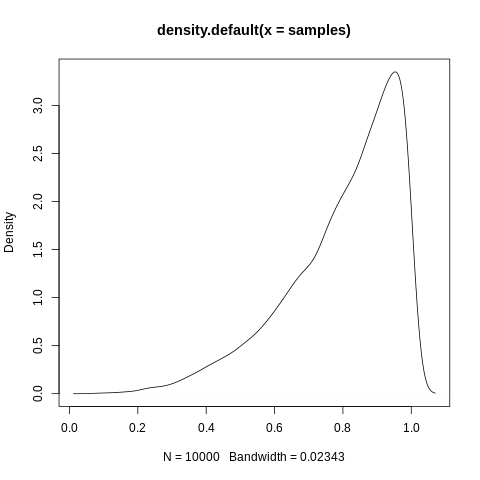

In [48]:
%%R

plot(density(samples), adjust=0.01)

In [49]:
@tf.function()
def kde(samples, adjust=1., n=512):
    quartiles = tfp.stats.quantiles(samples, 4)
    sd = tfp.stats.stddev(samples)
    iqr = quartiles[3]-quartiles[1]
    # Silverman's (1986) rule of thumb:
    bw = adjust*0.9*samples.shape[0]**(1./5)*tf.minimum(iqr/1.34,sd)
    minx = quartiles[0] - 2*bw
    maxx = quartiles[4] + 2*bw
    xs = tf.linspace(minx, maxx, n)
    binned_samples = tf.cast(tf.histogram_fixed_width(
        samples, [minx, maxx], n), dtype=samples.dtype)
    kernels = tfd.Normal(loc=xs,scale=bw).prob(xs[:,tf.newaxis])
    ys = (tf.tensordot(binned_samples, kernels, [[0],[1]]) / samples.shape[0])
    return xs,ys

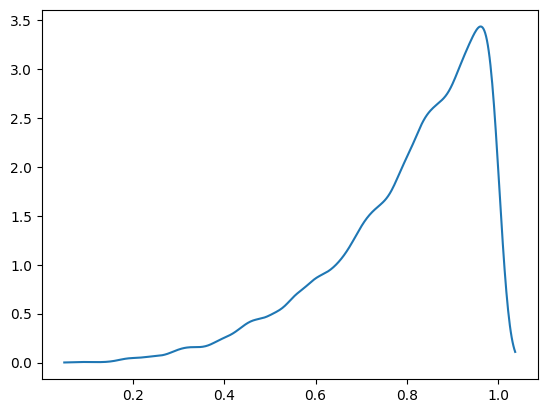

In [50]:
xs,ys = kde(samples, adjust=0.02)
plt.plot(xs,ys)

Now we can implement the chainmode function, and finally the code in the solution.

In [51]:
def chainmode(samples, *args, **nargs):
    xs,ys = kde(samples, *args, **nargs)
    return xs[tfm.argmax(ys)]

In [52]:
chainmode(samples, adjust=0.02)

<tf.Tensor: shape=(), dtype=float32, numpy=0.9618903>

We first implement a KDE in JAX

In [53]:
@partial(jax.jit, static_argnames=['n'])
def jkde(samples, adjust=1., n=512):
    m = samples.shape[0]
    sorted_samples = jnp.sort(samples)
    iqr = sorted_samples[3*m//4] - sorted_samples[m//4]
    sd = jnp.std(sorted_samples)
    # Silverman's (1986) rule of thumb:
    bw = adjust*0.9*samples.shape[0]**(1./5)*jnp.minimum(iqr/1.34,sd)
    minx = sorted_samples[0] - 2*bw
    maxx = sorted_samples[-1] + 2*bw
    bins = jnp.linspace(minx, maxx, n+1)
    binned_samples,_ = jnp.histogram(
        sorted_samples,
        bins=bins,
        range=(minx, maxx),
        density=True
    )
    xs = (bins[1:] + bins[:-1])/2
    kernels = jtfd.Normal(xs, bw).prob(xs[:,jnp.newaxis])
    ys = jnp.tensordot(binned_samples, kernels, [[0],[1]])
    return xs,ys

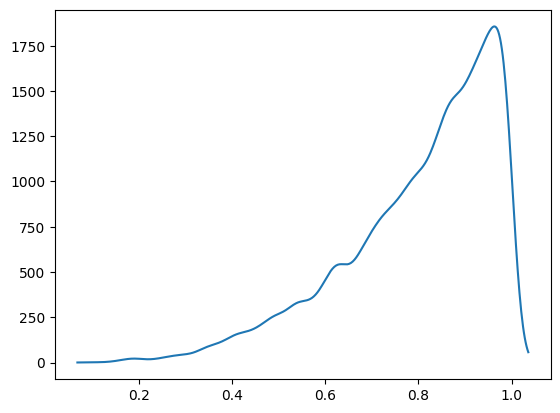

In [54]:
xs,ys = jkde(jsamples, adjust=0.02)
plt.plot(xs,ys)

Now we can implement the chainmode function, and finally the code in the solution.

In [55]:
def jchainmode(samples, *args, **nargs):
    xs,ys = jkde(samples, *args, **nargs)
    return xs[jnp.argmax(ys)]

In [56]:
jchainmode(jsamples, adjust=0.02)

Array(0.96394145, dtype=float32)

### 3.16

In [57]:
%%R

c(mean(samples),median(samples))

[1] 0.8001439 0.8408408


In [58]:
tfm.reduce_mean(samples), tfp.stats.percentile(samples, 50)

(<tf.Tensor: shape=(), dtype=float32, numpy=0.79981047>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.8398398>)

In [59]:
jnp.mean(jsamples), jnp.median(jsamples)

(Array(0.8021951, dtype=float32), Array(0.8448448, dtype=float32))

### 3.17

In [60]:
%%R

sum(posterior*abs(0.5 - p_grid))

[1] 0.3128752


In [61]:
tfm.reduce_sum(posterior*abs(0.5 - p_grid))

<tf.Tensor: shape=(), dtype=float32, numpy=0.31287518>

In [62]:
jnp.sum(jposterior*jnp.abs(0.5 - jp_grid))

Array(0.31287518, dtype=float32)

### 3.18

In [63]:
%%R

loss <- sapply(p_grid, function(d) sum(posterior*abs(d - p_grid)))
loss[1+(0:9)*100]

 [1] 0.8004001 0.7003040 0.6003283 0.5010747 0.4041080 0.3124371 0.2309969
 [8] 0.1671293 0.1310650 0.1364048


While tf.map_fn would be closer to sapply, it seems more natural to express it in a vectorized fashion in tensorflow.

In [64]:
loss = tfm.reduce_sum(posterior[:,tf.newaxis]*abs(
    p_grid[tf.newaxis,:] - p_grid[:,tf.newaxis]), axis=0)
loss[0:1000:100]

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([0.8004001 , 0.7003039 , 0.6003284 , 0.50107473, 0.40410802,
       0.31243712, 0.23099689, 0.16712926, 0.13106498, 0.13640475],
      dtype=float32)>

In [65]:
jloss = (
    jposterior[:,jnp.newaxis] * jnp.abs(
        jp_grid[jnp.newaxis,:] - jp_grid[:,jnp.newaxis]
    )
).sum(axis=0)
jloss[0:1000:100]

Array([0.80040014, 0.70030403, 0.6003283 , 0.50107473, 0.40410802,
       0.31243712, 0.23099688, 0.16712928, 0.131065  , 0.13640475],      dtype=float32)

### 3.19

In [66]:
%%R

p_grid[which.min(loss)]

[1] 0.8408408


In [67]:
p_grid[tf.argmin(loss)]

<tf.Tensor: shape=(), dtype=float32, numpy=0.8408408>

In [68]:
jp_grid[jnp.argmin(jloss)]

Array(0.8408408, dtype=float32)

### 3.20

In [69]:
%%R

dbinom(0:2, size=2, prob=0.7)

[1] 0.09 0.42 0.49


In [70]:
tfd.Binomial(2, probs=0.7).prob(tf.range(3.))

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([0.09      , 0.42000034, 0.49      ], dtype=float32)>

In [71]:
jtfd.Binomial(2, probs=0.7).prob(jnp.arange(3))

Array([0.08999996, 0.42000034, 0.48999983], dtype=float32)

### 3.21

In [72]:
%%R

rbinom(1, size=2, prob=0.7)

[1] 2


In [73]:
tfd.Binomial(2, probs=0.7).sample(1)

<tf.Tensor: shape=(1,), dtype=float32, numpy=array([2.], dtype=float32)>

In [74]:
key = jr.key(42)
jtfd.Binomial(2, probs=0.7).sample(1, seed=key)

Array([1.], dtype=float32)

### 3.22

In [75]:
%%R

rbinom(10, size=2, prob=0.7)

 [1] 1 1 2 2 1 1 2 0 2 2


In [76]:
tfd.Binomial(2, probs=0.7).sample(10)

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([2., 2., 2., 1., 2., 2., 2., 1., 2., 1.], dtype=float32)>

In [77]:
key = jr.key(42)
jtfd.Binomial(2, probs=0.7).sample(10, seed=key)

Array([1., 1., 2., 1., 1., 1., 0., 2., 2., 2.], dtype=float32)

### 3.23

In [78]:
%%R

dummy_w <- rbinom(1e5, size=2, prob=0.7)
table(dummy_w)/1e5

dummy_w
      0       1       2 
0.08904 0.41940 0.49156 


In [79]:
num_tosses = 2
dummy_w = tfd.Binomial(num_tosses, probs=0.7).sample(10**5)
tf.reduce_sum(tf.one_hot(tf.cast(dummy_w, tf.int32), num_tosses+1), axis=0) / (
    len(dummy_w) )

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([0.08959, 0.41773, 0.49268], dtype=float32)>

In [80]:
num_tosses = 2
key = jr.key(42)
dummy_w = jtfd.Binomial(num_tosses, probs=0.7).sample(1e5, seed=key).astype(int)
jnp.eye(num_tosses+1)[dummy_w].sum(axis=0)/dummy_w.shape[0]

Array([0.08977, 0.42191, 0.48832], dtype=float32)

### 3.23

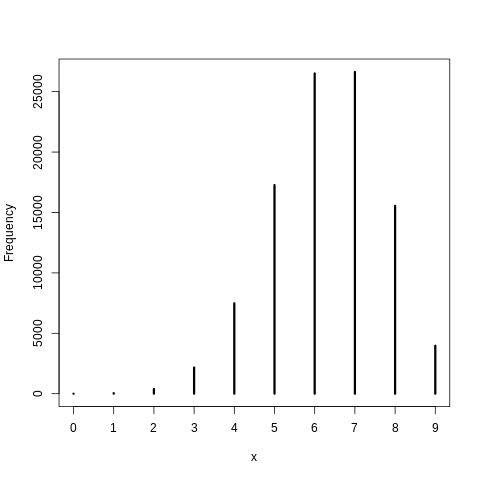

In [81]:
%%R

dummy_w <- rbinom(1e5, size=9, prob=0.7)
simplehist(dummy_w)

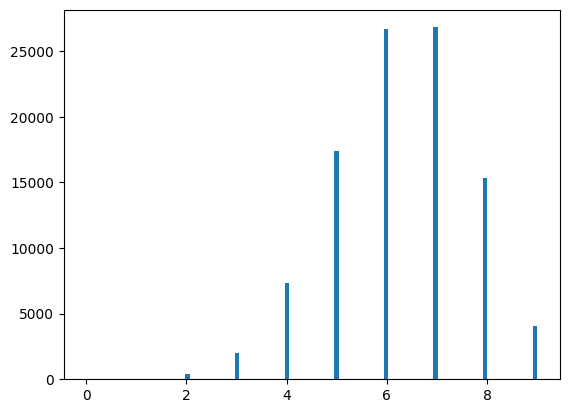

In [82]:
num_tosses = 9
dummy_w = tfd.Binomial(num_tosses, probs=0.7).sample(10**5)
plt.hist(dummy_w, bins=100);

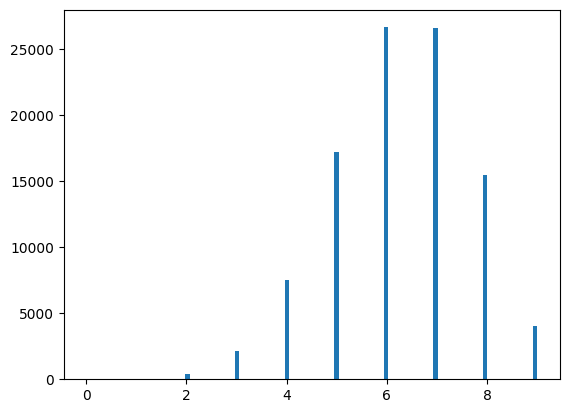

In [83]:
num_tosses = 9
seed = jr.key(42)
dummy_w = jtfd.Binomial(num_tosses, probs=0.7).sample(10**5, seed=seed)
plt.hist(dummy_w, bins=100);

### 3.25

In [84]:
%%R

w <- rbinom(1e4, size=9, prob=0.6)

In [85]:
w = tfd.Binomial(9, probs=0.6).sample(1e4)

In [86]:
w = tfd.Binomial(9, probs=0.6).sample(1e4)

### 3.26

In [87]:
%%R

w <- rbinom(1e4, size=9, prob=samples)

In [88]:
w = tfd.Binomial(9, probs=samples).sample()

In [89]:
seed = jr.key(42)
jw = jtfd.Binomial(9, probs=jsamples).sample(seed=seed)

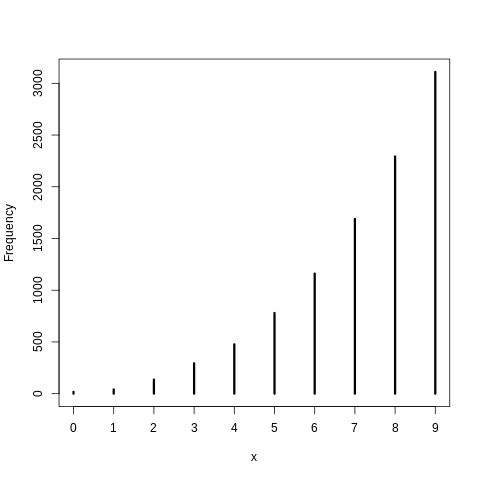

In [90]:
%%R

simplehist(w)

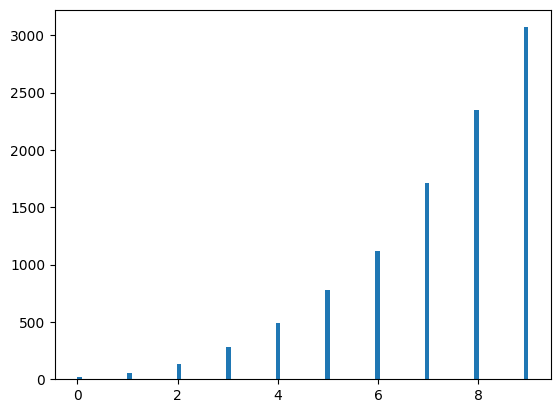

In [91]:
plt.hist(w, bins=100);

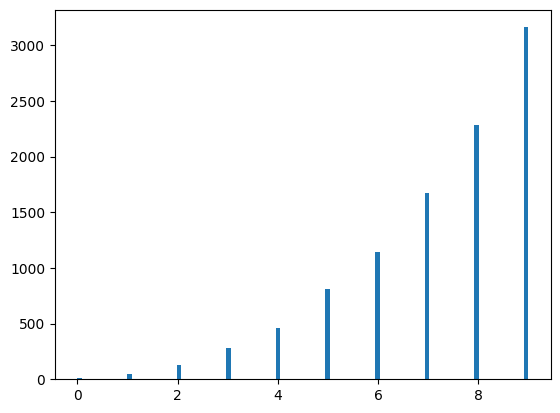

In [92]:
plt.hist(jw, bins=100);

### Practice

### 3.27

*NB:* Increased number of samples from $10^4$ to $10^6$ to reduce sampling noise and thus make it easier to compare implementations.

In [93]:
%%R

p_grid <- seq(from=0, to=1, length.out=1000)
prior <- rep(1,1000)
likelihood <- dbinom(6, size=9, prob=p_grid)
posterior <- likelihood*prior
posterior <- posterior / sum(posterior)
set.seed(100)
samples <- sample(p_grid, prob=posterior, size=1e6, replace=TRUE)

In [94]:
p_grid = tf.linspace(0., 1., 1000)
prior = tf.ones_like(p_grid)
likelihood = tfd.Binomial(9, probs=p_grid).prob(6)
posterior = likelihood*prior
posterior = posterior / tf.reduce_sum(posterior)
tf.random.set_seed(100)
samples = tf.gather(p_grid, tfd.Categorical(probs=posterior).sample(10**6))

In [95]:
jp_grid = jnp.linspace(0., 1., 1000)
jprior = jnp.ones_like(jp_grid)
jlikelihood = jtfd.Binomial(9, probs=jp_grid).prob(6)
jposterior = jlikelihood*jprior
jposterior = jposterior / jposterior.sum()
key,seed = jr.split(jr.key(42))
jsamples = jp_grid[jtfd.Categorical(probs=jposterior).sample(10**6, seed=seed)]

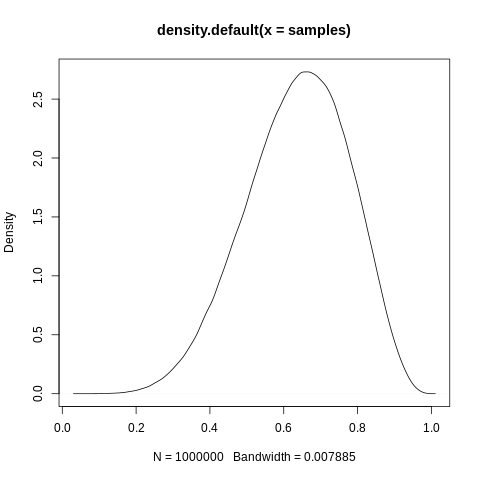

In [96]:
%%R

plot(density(samples))

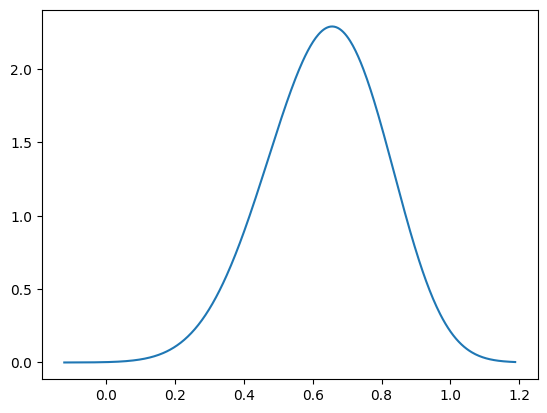

In [97]:
xs,ys = kde(samples, adjust=0.05)
plt.plot(xs,ys);

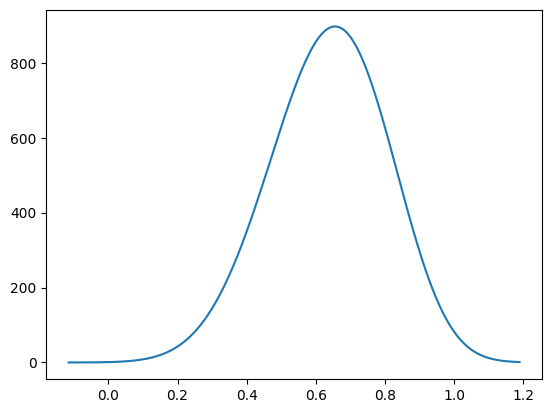

In [98]:
xs,ys = jkde(jsamples, adjust=0.05)
plt.plot(xs,ys);

### 3E1

In [99]:
%%R

sum(samples<0.2)/length(samples)

[1] 0.000871


In [100]:
tf.reduce_sum(tf.cast(samples < 0.2, tf.float32))/samples.shape[0]

<tf.Tensor: shape=(), dtype=float32, numpy=0.000879>

In [101]:
jnp.mean(jsamples < 0.2)

Array(0.0009, dtype=float32)

### 3E2

In [102]:
%%R

sum(samples > 0.8)/length(samples)

[1] 0.120409


In [103]:
tf.reduce_sum(tf.cast(samples > 0.8, tf.float32))/samples.shape[0]

<tf.Tensor: shape=(), dtype=float32, numpy=0.120794>

In [104]:
jnp.mean(jsamples > 0.8)

Array(0.120687, dtype=float32)

### 3E3

In [105]:
%%R

sum((samples > 0.2) & (samples < 0.8))/length(samples)

[1] 0.87872


In [106]:
tf.reduce_sum(
    tf.cast(tf.logical_and(samples > 0.2, samples < 0.8), tf.float32)
    )/samples.shape[0]

<tf.Tensor: shape=(), dtype=float32, numpy=0.878327>

In [107]:
jnp.mean((0.2 < jsamples) & (jsamples < 0.8))

Array(0.878413, dtype=float32)

### 3E4

In [108]:
%%R

quantile(samples, 0.2)

      20% 
0.5165165 


In [109]:
tfp.stats.percentile(samples, 20)

<tf.Tensor: shape=(), dtype=float32, numpy=0.5165165>

In [110]:
jtfp.stats.percentile(jsamples, 20)

Array(0.5155155, dtype=float32)

### 3E5

In [111]:
%%R

quantile(samples, 0.8)

      80% 
0.7607608 


In [112]:
tfp.stats.percentile(samples, 80)

<tf.Tensor: shape=(), dtype=float32, numpy=0.7607607>

In [113]:
jtfp.stats.percentile(jsamples, 80)

Array(0.7607607, dtype=float32)

### 3E6

In [114]:
%%R

HPDI(samples, 0.66)

    |0.66     0.66| 
0.5135135 0.7857858 


In [115]:
HPDI(samples, 0.66)

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([0.5165165, 0.7887888], dtype=float32)>

In [116]:
jHPDI(jsamples, 0.66)

Array([0.5105105, 0.7837838], dtype=float32)

### 3E7

In [117]:
%%R

quantile(samples, c(0.17, 0.83))

      17%       83% 
0.4984985 0.7747748 


In [118]:
tfp.stats.percentile(samples, [17, 83])

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([0.4984985, 0.7747748], dtype=float32)>

In [119]:
jtfp.stats.percentile(jsamples, [17, 83])

Array([0.4984985, 0.7747748], dtype=float32)

### 3M1

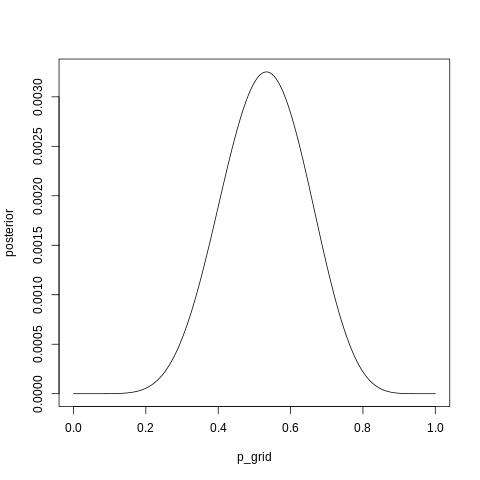

In [120]:
%%R

p_grid <- seq(from=0, to=1, length.out=1000)
prior <- rep(1,1000)
likelihood <- dbinom(8, size=15, prob=p_grid)
posterior <- likelihood*prior
posterior <- posterior / sum(posterior)

plot(p_grid, posterior, type="l")

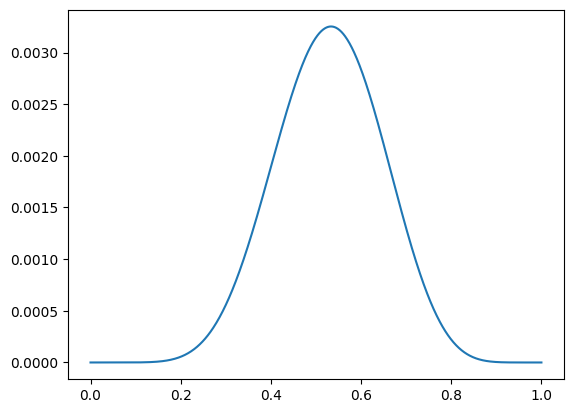

In [121]:
p_grid = tf.linspace(0., 1., 1000)
prior = tf.ones_like(p_grid)
likelihood = tfd.Binomial(15, probs=p_grid).prob(8)
posterior = likelihood*prior
posterior = posterior / tf.reduce_sum(posterior)
plt.plot(p_grid, posterior)

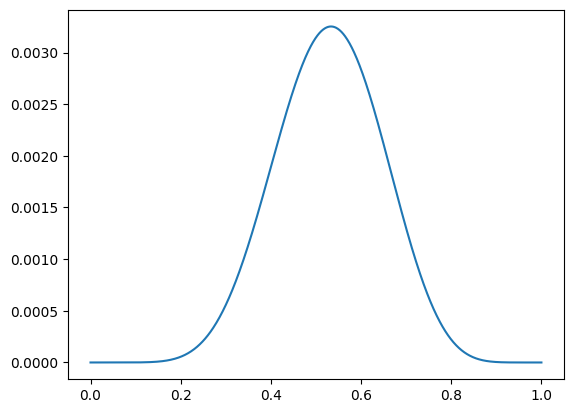

In [122]:
jp_grid = jnp.linspace(0., 1., 1000)
jprior = jnp.ones_like(jp_grid)
jlikelihood = jtfd.Binomial(15, probs=jp_grid).prob(8)
jposterior = jlikelihood*jprior
jposterior = jposterior / jposterior.sum()
plt.plot(jp_grid, jposterior)

### 3M2

We'll again modify the problem to generate $10^6$ samples (instead of $10^4$) to reduce sampling noise and thus make it easier to compare the python and R implementations.

In [123]:
%%R

set.seed(42)
samples <- sample(p_grid, prob=posterior, size=1e6, replace=TRUE)
HPDI(samples, 0.9)

     |0.9      0.9| 
0.3293293 0.7167167 


In [124]:
tf.random.set_seed(42)
samples = tf.gather(p_grid, tfd.Categorical(probs=posterior).sample(10**6))
HPDI(samples, 0.9)

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([0.33433434, 0.7207207 ], dtype=float32)>

In [125]:
key,seed = jr.split(jr.key(42))
jsamples = jp_grid[jtfd.Categorical(probs=jposterior).sample(10**6, seed=seed)]
jHPDI(jsamples, 0.9)

Array([0.33333334, 0.7207207 ], dtype=float32)

### 3M3

In [126]:
%%R

prediction_samples = rbinom(n=length(samples), size=15, prob=samples)
sum(prediction_samples == 8) / length(prediction_samples)

[1] 0.146826


In [127]:
prediction_samples = tfd.Binomial(15, probs=samples).sample()
tfm.reduce_mean(tf.cast(prediction_samples == 8, tf.float16))

<tf.Tensor: shape=(), dtype=float16, numpy=0.147>

In [128]:
key,seed = jr.split(key)
jprediction_samples = jtfd.Binomial(15, probs=jsamples).sample(seed=seed)
jnp.mean(jprediction_samples == 8)

Array(0.146649, dtype=float32)

### 3M4

In [129]:
%%R

prediction_samples = rbinom(n=length(samples), size=9, prob=samples)
sum(prediction_samples == 6) / length(prediction_samples)

[1] 0.177008


In [130]:
prediction_samples = tfd.Binomial(9, probs=samples).sample()
tfm.reduce_mean(tf.cast(prediction_samples == 6, tf.float16))

<tf.Tensor: shape=(), dtype=float16, numpy=0.1761>

In [131]:
key,seed = jr.split(key)
jprediction_samples = jtfd.Binomial(9, probs=jsamples).sample(seed=seed)
jnp.mean(jprediction_samples == 6)

Array(0.17628, dtype=float32)

### 3M5
#### 3M5.M1

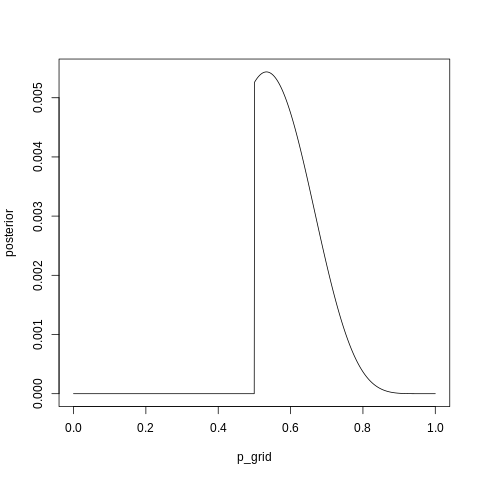

In [132]:
%%R

p_grid <- seq(from=0, to=1, length.out=1000)
prior <- c(rep(0,500), rep(1,500))
likelihood <- dbinom(8, size=15, prob=p_grid)
posterior <- likelihood*prior
posterior <- posterior / sum(posterior)

plot(p_grid, posterior, type="l")

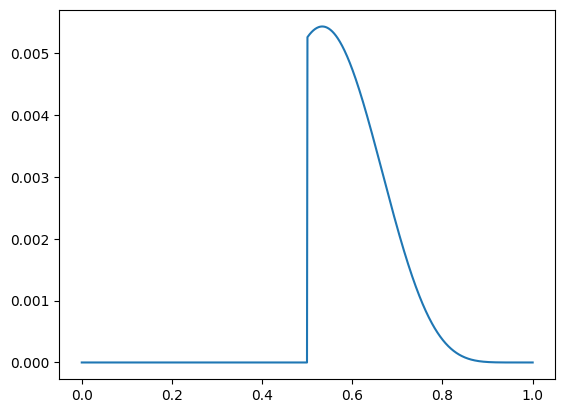

In [133]:
p_grid = tf.linspace(0., 1., 1000)
prior = tf.cast(p_grid > 0.5, p_grid.dtype)
likelihood = tfd.Binomial(15, probs=p_grid).prob(8)
posterior = likelihood*prior
posterior = posterior / tf.reduce_sum(posterior)
plt.plot(p_grid, posterior)

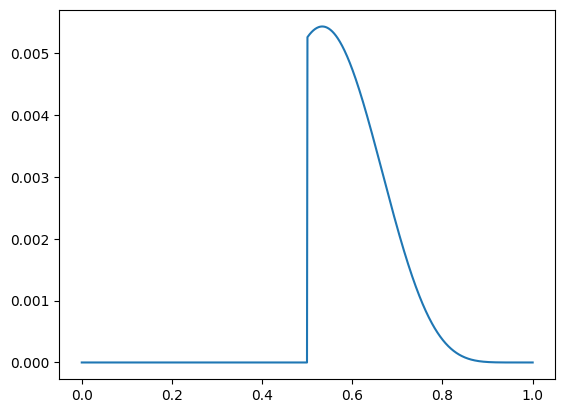

In [134]:
jp_grid = jnp.linspace(0., 1., 1000)
jprior = jp_grid > 0.5
jlikelihood = jtfd.Binomial(15, probs=jp_grid).prob(8)
jposterior = jlikelihood*jprior
jposterior = jposterior / jposterior.sum()
plt.plot(jp_grid, jposterior)

#### 3M5.M2

We'll again modify the problem to generate $10^6$ samples (instead of $10^4$) to reduce sampling noise and thus make it easier to compare the python and R implementations.

In [135]:
%%R

set.seed(42)
samples <- sample(p_grid, prob=posterior, size=1e6, replace=TRUE)
HPDI(samples, 0.9)

     |0.9      0.9| 
0.5005005 0.7117117 


In [136]:
tf.random.set_seed(42)
samples = tf.gather(p_grid, tfd.Categorical(probs=posterior).sample(10**6))
HPDI(samples, 0.9)

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([0.5005005, 0.7117117], dtype=float32)>

In [137]:
key,seed = jr.split(jr.key(42))
jsamples = jp_grid[jtfd.Categorical(probs=jposterior).sample(10**6, seed=seed)]
jHPDI(jsamples, 0.9)

Array([0.5005005, 0.7117117], dtype=float32)

#### 3M5.M3

In [138]:
%%R

prediction_samples = rbinom(n=length(samples), size=15, prob=samples)
print(sum(prediction_samples == 8) / length(prediction_samples))
print(dbinom(8, size=15, prob=0.7))

[1] 0.157816
[1] 0.08113003


In [139]:
prediction_samples = tfd.Binomial(15, probs=samples).sample()
pred = tfm.reduce_mean(tf.cast(prediction_samples == 8, tf.float16))
ideal = tfd.Binomial(15, probs=0.7).prob(8)
print(f'predicted: {pred:.3f}, ideal {ideal:.3f}')

predicted: 0.157, ideal 0.081


In [140]:
key,seed = jr.split(jr.key(42))
jprediction_samples = jtfd.Binomial(15, probs=jsamples).sample(seed=seed)
jpred = (jprediction_samples == 8).mean()
jideal = jtfd.Binomial(15, probs=0.7).prob(8)
print(f'predicted: {jpred:.3f}, ideal {jideal:.3f}')

predicted: 0.158, ideal 0.081


#### 3M5.M4

In [141]:
%%R

prediction_samples = rbinom(n=length(samples), size=9, prob=samples)
print(sum(prediction_samples == 6) / length(prediction_samples))
print(dbinom(6, size=9, prob=0.7))

[1] 0.232274
[1] 0.2668279


In [142]:
prediction_samples = tfd.Binomial(9, probs=samples).sample()
pred = tfm.reduce_mean(tf.cast(prediction_samples == 6, tf.float16))
ideal = tfd.Binomial(9, probs=0.7).prob(6)
print(f'predicted: {pred:.3f}, ideal {ideal:.3f}')

predicted: 0.232, ideal 0.267


In [143]:
key,seed = jr.split(jr.key(42))
jprediction_samples = jtfd.Binomial(9, probs=jsamples).sample(seed=seed)
jpred = (jprediction_samples == 6).mean()
jideal = jtfd.Binomial(9, probs=0.7).prob(6)
print(f'predicted: {jpred:.3f}, ideal {jideal:.3f}')

predicted: 0.232, ideal 0.267


### 3M6

One way to do this would be to use the closed form version of the prior, because we do have it for this problem.  In general, however, we will need to numerically sample from the prior, so we'll use that approach here.

In [144]:
%%R

target_width <- 0.05
target_ci <- 0.99
power <- 0.5
samples_per_n <- 10000

interval_simulation <- function (n_tosses, p) {
    p_grid <- seq(from=0, to=1, length.out=10000)
    prior <- rep(1,length(p_grid))
    likelihood <- dbinom(rbinom(1,n_tosses,p), size=n_tosses, prob=p_grid)
    posterior <- likelihood*prior
    posterior <- posterior / sum(posterior)
    posterior_cdf <- cumsum(posterior)
    lbound <- min(p_grid[posterior_cdf > (1-target_ci)/2])
    ubound <- min(p_grid[posterior_cdf > 1 - (1-target_ci)/2])
    return(ubound - lbound)
}

interval_simulation_set <- function(n_tosses, samples_per_n, power) {
    ps <- runif(samples_per_n)
    widths <- sapply(ps, function (p) interval_simulation(n_tosses, p))
    return(quantile(widths, power))
}

# first, find an upper bound on the size
ubound <- 1
lbound <- 0
lwidth <- 1
uwidth <- 1
while (uwidth > target_width) {
    lbound <- ubound
    ubound <- ubound * 2
    lwidth <- uwidth
    uwidth <- interval_simulation_set(ubound, samples_per_n, power)
    print(c(lbound, ubound, lwidth, uwidth))
}

# now do a binary search
while (ubound - lbound > 1) {
    midpoint <- floor(mean(c(lbound, ubound)))
    width <- interval_simulation_set(ubound, samples_per_n, power)
    if (width > target_width) {
        lbound <- midpoint
        lwidth <- width
    } else {
        ubound <- midpoint
        uwidth <- width
    }
    print(c(lbound, ubound, lwidth, uwidth))
}

print("final result:")
print(ubound)

                                    50% 
1.0000000 2.0000000 1.0000000 0.8273827 
                          50%       50% 
2.0000000 4.0000000 0.8273827 0.7919792 
                          50%       50% 
4.0000000 8.0000000 0.7919792 0.6509651 
                             50%        50% 
 8.0000000 16.0000000  0.6509651  0.5034503 
                             50%        50% 
16.0000000 32.0000000  0.5034503  0.3740374 
                             50%        50% 
32.0000000 64.0000000  0.3740374  0.2714271 
                                50%         50% 
 64.0000000 128.0000000   0.2714271   0.1945195 
                                50%         50% 
128.0000000 256.0000000   0.1945195   0.1384138 
                                   50%          50% 
256.00000000 512.00000000   0.13841384   0.09850985 
                                   50%          50% 
5.120000e+02 1.024000e+03 9.850985e-02 6.980698e-02 
                                   50%          50% 
1.024000e+03 2.048000e+

In [145]:
target_width = 0.05
target_ci = 0.99
power = 0.5
samples_per_n = 10000

@tf.function
def interval_simulation(n_tosses, p):
    p_grid = tf.linspace(tf.zeros((), p.dtype), tf.ones((), p.dtype), 10000)
    prior = tf.ones_like(p_grid)
    sample = tfd.Binomial(n_tosses, probs=p).sample()
    likelihood = tfd.Binomial(n_tosses, probs=p_grid[tf.newaxis, :]).prob(
        sample[:, tf.newaxis])
    posterior_unormalized = likelihood*prior[tf.newaxis, :]
    posterior = posterior_unormalized / (
        tfm.reduce_sum(posterior_unormalized, axis=1, keepdims=True))
    posterior_cdf = tfm.cumsum(posterior, axis=1)
    expanded_p_grid = tf.tile(p_grid[tf.newaxis, :], [p.shape[0], 1])
    #print(posterior_cdf)
    lbound = tf.ragged.boolean_mask(expanded_p_grid,
        posterior_cdf >= tf.constant((1.-target_ci)/2,p.dtype)
                                   )[:, :1].flat_values
    ubound = tf.ragged.boolean_mask(expanded_p_grid,
        posterior_cdf > tf.constant(1 - (1.-target_ci)/2,p.dtype)
                                   )[:, :1].flat_values
    return(ubound - lbound)

def interval_simulation_set(n_tosses, samples_per_n, power):
    dtype = tf.float32
    ps = tfd.Uniform(tf.zeros((),dtype), tf.ones((),dtype)).sample(
        samples_per_n)
    widths = interval_simulation(tf.constant(n_tosses, dtype), ps)
    return tfp.stats.percentile(widths, 100*power)

# first, find an upper bound on the size
ubound = 1
lbound = 0
lwidth = 1
uwidth = 1
while (uwidth > target_width):
    lbound = ubound
    ubound = ubound * 2
    lwidth = uwidth
    uwidth = interval_simulation_set(ubound, samples_per_n, power)
    print(f'({lbound}, {ubound}), ({lwidth:.4f}, {uwidth:.4f})')

# now do a binary search
while (ubound - lbound > 1):
    midpoint = math.floor((lbound + ubound)/2)
    width = interval_simulation_set(ubound, samples_per_n, power)
    if (width > target_width):
        lbound = midpoint
        lwidth = width
    else:
        ubound = midpoint
        uwidth = width
    print(f'({lbound}, {ubound}), ({lwidth:.4f}, {uwidth:.4f})')

print("final result:")
print(ubound)

(1, 2), (1.0000, 0.8274)
(2, 4), (0.8274, 0.7920)
(4, 8), (0.7920, 0.6510)
(8, 16), (0.6510, 0.5035)
(16, 32), (0.5035, 0.3740)
(32, 64), (0.3740, 0.2660)
(64, 128), (0.2660, 0.1945)
(128, 256), (0.1945, 0.1391)
(256, 512), (0.1391, 0.0980)
(512, 1024), (0.0980, 0.0691)
(1024, 2048), (0.0691, 0.0493)
(1024, 1536), (0.0691, 0.0491)
(1280, 1536), (0.0568, 0.0491)
(1408, 1536), (0.0568, 0.0491)
(1472, 1536), (0.0568, 0.0491)
(1504, 1536), (0.0571, 0.0491)
(1520, 1536), (0.0572, 0.0491)
(1528, 1536), (0.0567, 0.0491)
(1532, 1536), (0.0570, 0.0491)
(1534, 1536), (0.0570, 0.0491)
(1535, 1536), (0.0571, 0.0491)
final result:
1536


In [146]:
target_width = 0.05
target_ci = 0.99
power = 0.5
samples_per_n = 10000

@jax.jit
def interval_simulation(n_tosses, p, seed):
    n_tosses=jnp.float32(n_tosses)
    key = seed
    p_grid = jnp.linspace(jnp.zeros((), p.dtype), jnp.ones((), p.dtype), 10000)
    prior = jnp.ones_like(p_grid)
    key,seed = jr.split(key)
    sample = jtfd.Binomial(n_tosses, probs=p).sample(seed=seed)
    likelihood = jtfd.Binomial(n_tosses, probs=p_grid[jnp.newaxis, :]).prob(
        sample[:, jnp.newaxis])
    posterior_unormalized = likelihood*prior[jnp.newaxis, :]
    posterior = posterior_unormalized / posterior_unormalized.sum(axis=1, keepdims=True)
    posterior_cdf = jnp.cumsum(posterior, axis=1)
    prob_lbound = (1.-target_ci)/2
    prob_ubound = 1 - (1.-target_ci)/2
    lbound_mask = (posterior_cdf[:,:-1] < prob_lbound) & (posterior_cdf[:,1:] >= prob_lbound)
    ubound_mask = (posterior_cdf[:,:-1] < prob_ubound) & (posterior_cdf[:,1:] >= prob_ubound)
    expanded_p_grid = jnp.tile(p_grid[tf.newaxis, :-1], [p.shape[0], 1])
    lbound = (expanded_p_grid * lbound_mask).sum(axis=1)
    ubound = (expanded_p_grid * ubound_mask).sum(axis=1)

    return(ubound - lbound)

def interval_simulation_set(n_tosses, samples_per_n, power, seed):
    seed1,seed2 = jr.split(seed)
    ps = jtfd.Uniform(jnp.zeros((),), jnp.ones((),)).sample(
        samples_per_n, seed=seed1)
    widths = interval_simulation(n_tosses, ps, seed2)
    return jtfp.stats.percentile(widths, 100*power)

key = jr.key(42)
# first, find an upper bound on the size
ubound = 1
lbound = 0
lwidth = 1
uwidth = 1
while (uwidth > target_width):
    lbound = ubound
    ubound = ubound * 2
    lwidth = uwidth
    seed,key = jr.split(key)
    uwidth = interval_simulation_set(ubound, samples_per_n, power, seed)
    print(f'({lbound}, {ubound}), ({lwidth:.4f}, {uwidth:.4f})')

# now do a binary search
while (ubound - lbound > 1):
    midpoint = math.floor((lbound + ubound)/2)
    seed,key = jr.split(key)
    width = interval_simulation_set(ubound, samples_per_n, power, seed)
    if (width > target_width):
        lbound = midpoint
        lwidth = width
    else:
        ubound = midpoint
        uwidth = width
    print(f'({lbound}, {ubound}), ({lwidth:.4f}, {uwidth:.4f})')

print("final result:")
print(ubound)

(1, 2), (1.0000, 0.8274)
(2, 4), (0.8274, 0.7920)
(4, 8), (0.7920, 0.6510)
(8, 16), (0.6510, 0.5035)
(16, 32), (0.5035, 0.3740)
(32, 64), (0.3740, 0.2714)
(64, 128), (0.2714, 0.1945)
(128, 256), (0.1945, 0.1378)
(256, 512), (0.1378, 0.0983)
(512, 1024), (0.0983, 0.0694)
(1024, 2048), (0.0694, 0.0493)
(1024, 1536), (0.0694, 0.0491)
(1280, 1536), (0.0567, 0.0491)
(1408, 1536), (0.0570, 0.0491)
(1472, 1536), (0.0566, 0.0491)
(1504, 1536), (0.0570, 0.0491)
(1520, 1536), (0.0566, 0.0491)
(1528, 1536), (0.0568, 0.0491)
(1532, 1536), (0.0563, 0.0491)
(1534, 1536), (0.0570, 0.0491)
(1535, 1536), (0.0568, 0.0491)
final result:
1536


### 3H problem dataset

In [147]:
%%R
library(rethinking)
data(homeworkch3)
sum(birth1) + sum(birth2)

[1] 111


I'm running into some strange errors with this particular dataset when trying to load it using RPy, so we'll just write it out in R and reload it in python.

In [148]:
%%R
write.csv(birth1, '/tmp/birth1.csv', row.names=F)
write.csv(birth2, '/tmp/birth2.csv', row.names=F)

In [149]:
birth1 = np.loadtxt('/tmp/birth1.csv', dtype=int, skiprows=1)
birth2 = np.loadtxt('/tmp/birth2.csv', dtype=int, skiprows=1)
sum(birth1) + sum(birth2)

111

### 3H1

In [150]:
%%R
p_grid <- seq(from=0, to=1, length.out=10000)
prior <- rep(1,length(p_grid))
prob_data <- dbinom(sum(birth1) + sum(birth2), size=length(birth1) + length(birth2), prob=p_grid)
posterior <- prob_data * prior
posterior <- posterior / sum(posterior)
p_grid[which.max(posterior)]

[1] 0.5549555


In [151]:
p_grid = tf.linspace(0., 1., 10000)
prob_p = tf.ones_like(p_grid)
prob_data = tfd.Binomial(len(birth1) + len(birth2), probs=p_grid).prob(sum(birth1) + sum(birth2))
posterior = prob_data * prob_p
posterior = posterior / tfm.reduce_sum(posterior)
float(p_grid[tf.argmax(posterior)])

0.554855465888977

In [152]:
jp_grid = jnp.linspace(0., 1., 10000)
jprob_p = jnp.ones_like(jp_grid)
jprob_data = jtfd.Binomial(len(birth1) + len(birth2), probs=jp_grid).prob(sum(birth1) + sum(birth2))
jposterior = jprob_data * jprob_p
jposterior = jposterior / jposterior.sum()
float(jp_grid[jnp.argmax(jposterior)])

0.554855465888977

### 3H2

In [153]:
%%R

ranges <- c(0.5, 0.89, 0.97)
posterior_sample <- sample(p_grid, 10000, replace=TRUE, prob=posterior)
d <- t(sapply(ranges, function (x) { c(HPDI(posterior_sample, x)) } ))
rownames(d) <- lapply(ranges, function (x) paste(100*x, "%", sep=''))
colnames(d) <- c('low', 'high')
d

          low      high
50% 0.5277528 0.5747575
89% 0.5018502 0.6129613
97% 0.4795480 0.6316632


In [154]:
ranges = tf.constant([0.5, 0.89, 0.97])
posterior_sample = tf.gather(p_grid, tfd.Categorical(probs=posterior).sample(10000))
results = tf.stack([HPDI(posterior_sample, p) for p in ranges])
pd.DataFrame(results, dtype=float, columns=['min', 'max'],
    index=[f"{float(x) * 100 :.0f}%" for x in ranges])

,min,max
50%,0.531253,0.578458
89%,0.500450,0.610261
97%,0.476148,0.626463


In [155]:
ranges = jnp.array([0.5, 0.89, 0.97])
key = jr.key(42)
seed, key = jr.split(key)
jposterior_sample = jr.choice(a=jp_grid, p=jposterior, shape=(10000,), key=seed)
jresults = tf.stack([jHPDI(jposterior_sample, p) for p in ranges])
pd.DataFrame(jresults, dtype=float, columns=['min', 'max'],
    index=[f"{float(x) * 100 :.0f}%" for x in ranges])

,min,max
50%,0.532953,0.579758
89%,0.499950,0.610361
97%,0.478748,0.629563


### 3H3

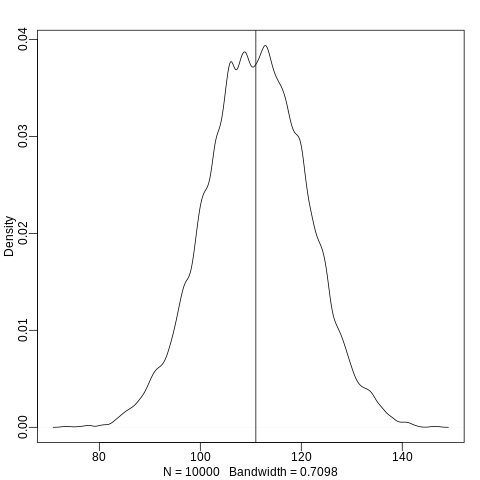

In [156]:
%%R

posterior_p_sample = sample(p_grid, 10000, replace=TRUE, prob=posterior)
posterior_m_sample = sapply(posterior_p_sample, function(p) rbinom(1, 200, p))
dens(posterior_m_sample)
abline(v=sum(birth1) + sum(birth2))

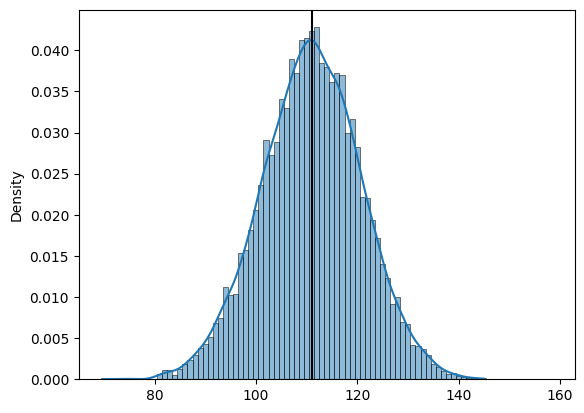

In [157]:
posterior_p_sample = tf.gather(p_grid, tfd.Categorical(probs=posterior).sample(10000))
posterior_m_sample = tfd.Binomial(200, probs=posterior_p_sample).sample()
sns.histplot(posterior_m_sample, kde=True, stat='density', bins=tf.range(70,160,dtype=tf.float32)-0.5)
plt.axvline(x=birth1.sum() + birth2.sum(), c='black')

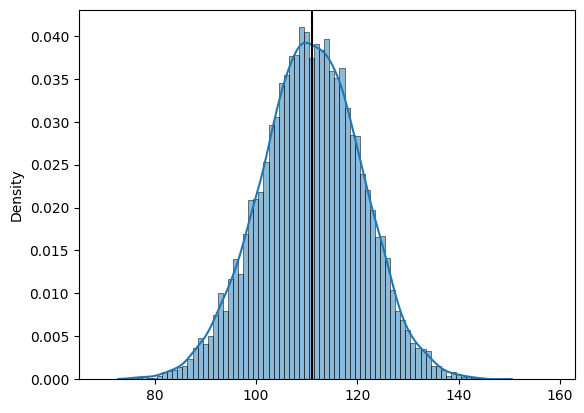

In [158]:
seed1, seed2, key = jr.split(key, 3)
jposterior_p_sample = jr.choice(a=jp_grid, p=jposterior, shape=(10000,), key=seed1)
jposterior_m_sample = jtfd.Binomial(200, probs=jposterior_p_sample).sample(seed=seed2)
sns.histplot(jposterior_m_sample, kde=True, stat='density', bins=jnp.arange(70,160)-0.5)
plt.axvline(x=birth1.sum() + birth2.sum(), c='black')

The model fits the total number of boys well.

### 3H4

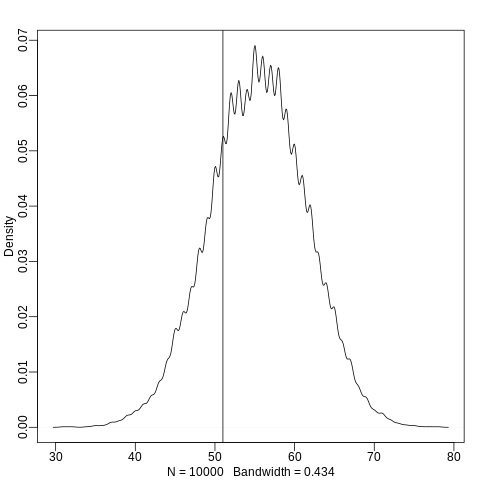

In [159]:
%%R

posterior_p_sample = sample(p_grid, 10000, replace=TRUE, prob=posterior)
posterior_m_sample = sapply(posterior_p_sample, function(p) rbinom(1, 100, p))
dens(posterior_m_sample)
abline(v=sum(birth1))

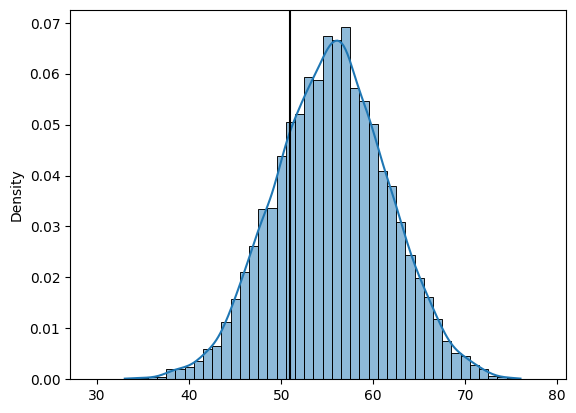

In [160]:
posterior_p_sample = tf.gather(p_grid, tfd.Categorical(probs=posterior).sample(10000))
posterior_m_sample = tfd.Binomial(100, probs=posterior_p_sample).sample()
sns.histplot(posterior_m_sample, kde=True, stat='density', bins=tf.range(30,80,dtype=tf.float32)-0.5)
plt.axvline(x=birth1.sum(), c='black')

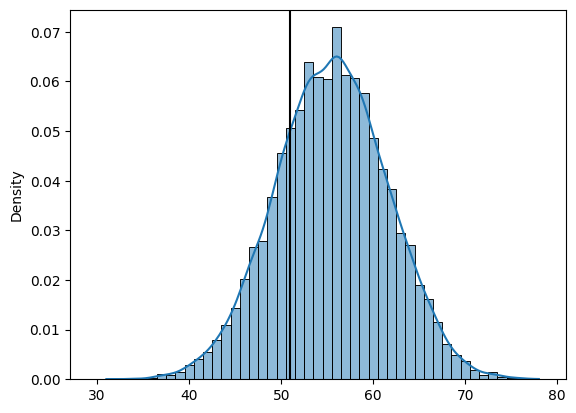

In [161]:
seed1, seed2, key = jr.split(key, 3)
jposterior_p_sample = jr.choice(a=jp_grid, p=jposterior, shape=(10000,), key=seed1)
jposterior_m_sample = jtfd.Binomial(100, probs=jposterior_p_sample).sample(seed=seed2)
sns.histplot(jposterior_m_sample, kde=True, stat='density', bins=jnp.arange(30,80)-0.5)
plt.axvline(x=birth1.sum(), c='black')

The model fit is still reasonable, but not as good as the previous fit.

### 3H5

[1] 49


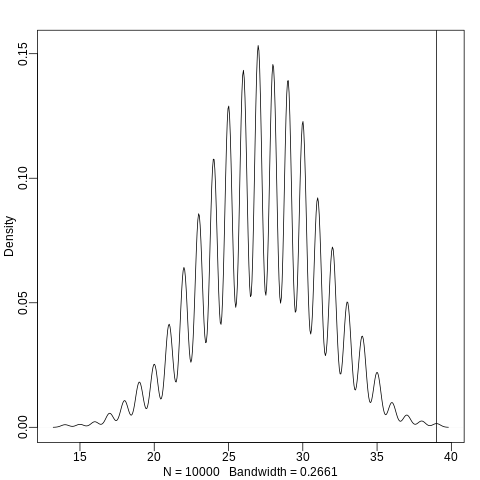

In [162]:
%%R

n_female_first_births = sum(1 - birth1)
print(n_female_first_births)
posterior_p_sample = sample(p_grid, 10000, replace=TRUE, prob=posterior)
posterior_m_sample = sapply(posterior_p_sample, function(p) rbinom(1, n_female_first_births, p))
dens(posterior_m_sample)
abline(v=sum(birth2 * (1 - birth1)))

In [163]:
n_female_first_births = (1 - birth1).sum()
n_female_first_births

49

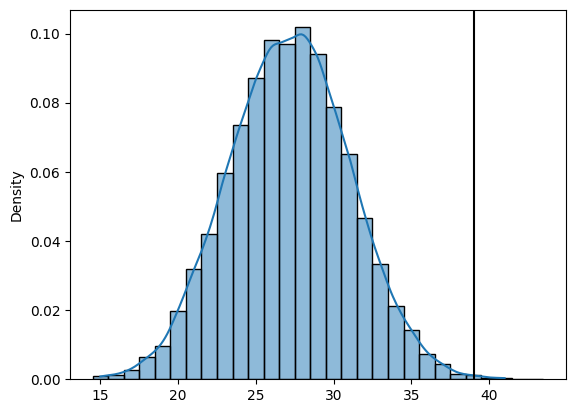

In [164]:
posterior_p_sample = tf.gather(p_grid, tfd.Categorical(probs=posterior).sample(10000))
posterior_m_sample = tfd.Binomial(float(n_female_first_births), probs=posterior_p_sample).sample()
sns.histplot(posterior_m_sample, kde=True, stat='density', bins=tf.range(15,45,dtype=tf.float32)-0.5)
plt.axvline(x=((1-birth1)*birth2).sum(), c='black')

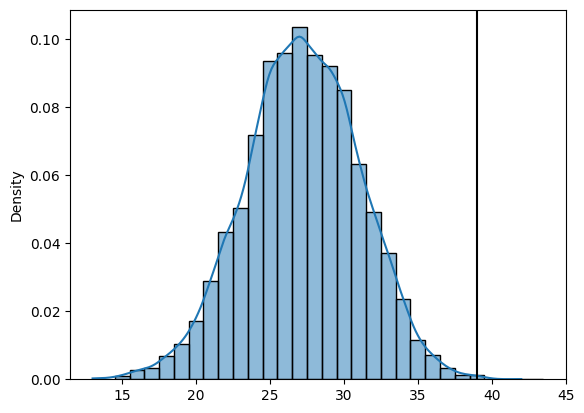

In [165]:
seed1, seed2, key = jr.split(key, 3)
jposterior_p_sample = jr.choice(a=jp_grid, p=jposterior, shape=(10000,), key=seed1)
jposterior_m_sample = jtfd.Binomial(float(n_female_first_births), probs=jposterior_p_sample).sample(seed=seed2)
sns.histplot(jposterior_m_sample, kde=True, stat='density', bins=jnp.arange(15,45)-0.5)
plt.axvline(x=((1-birth1)*birth2).sum(), c='black')

The data do not seem consistent with the model in this respect. There are many possible explainations, ranging from evolved r-k type strategies (less likely) to artificial selection of males (e.g. through IVF embryo selection or abortions) to meet societial pressures (e.g. a male heir for the family name).